# Dereverberation

Description

In [68]:
# Reload the notebook if an external file is updated
%load_ext autoreload
%autoreload 2

import sys

from pathlib import Path

path = str(Path.cwd().parent)
sys.path.append(path)

In [69]:
import io
import IPython
import matplotlib.pyplot as plt
import numpy as np
import soundfile as sf

from constant import DATASET
from datatype.axes import SpectrogramAxes
from datatype.parameters import Parameters
from datatype.signal import Signal
from datatype.spectrogram import Spectrogram
from nara_wpe.wpe import wpe
from nara_wpe.wpe import get_power
from nara_wpe.utils import stft, istft, get_stft_center_frequencies
from pathlib import Path
from plot import (
    CutoffSpectrogram,
    GenericSpectrogram,
    LusciniaSpectrogram
)
from scipy.io import wavfile
from tqdm import tqdm

WPE estimates a filter to predict the current reverberation tail frame from K time frames which lie 3 (delay) time frames in the past. 

This frame (reverberation tail) is then subtracted from the observed signal.

### Setup

In [70]:
channels = 2
sampling_rate = 44100
delay = 1
iterations = 500
taps = 10
alpha = 0.9999

### Audio data
Shape: (channels, frames)

In [71]:
path = DATASET.joinpath('DbWY_STE2017/parameters/STE05_DbWY2017.json')
parameters = Parameters.from_file(path)

path = DATASET.joinpath('DbWY_STE2017/recordings/STE05_DbWY2017.wav')
reverberated = Signal(path)

if parameters.bandpass_filter:
    reverberated.filter(
        parameters.butter_lowcut,
        parameters.butter_highcut
    )

if parameters.reduce_noise:
    reverberated.reduce()

In [72]:
# signals = [
#     signal.data.copy()
#     for channel in range(channels)
# ]

y = np.stack([reverberated.data], axis=0)
IPython.display.Audio(y[0], rate=reverberated.rate)

### STFT
A STFT is performed to obtain a Numpy array with shape (frequency bins, channels, frames).

In [73]:
stft_options = dict(
    size=512, 
    shift=128
)

In [74]:
Y = stft(y, **stft_options).transpose(2, 0, 1)

### Iterative WPE
The wpe function is fed with Y. Finally, an inverse STFT is performed to obtain a dereverberated result in time domain. 

In [75]:
Z = wpe(
    Y,
    taps=taps,
    delay=delay,
    iterations=iterations,
    statistics_mode='full'
).transpose(1, 2, 0)

z = istft(
    Z, 
    size=stft_options['size'], 
    shift=stft_options['shift']
)

buffer = io.BytesIO()

wavfile.write(
    buffer,
    reverberated.rate,
    z[0]
)

dereverberated = Signal(buffer)

IPython.display.Audio(
    dereverberated.data, 
    rate=dereverberated.rate
)

## Power spectrum 
Before and after applying WPE

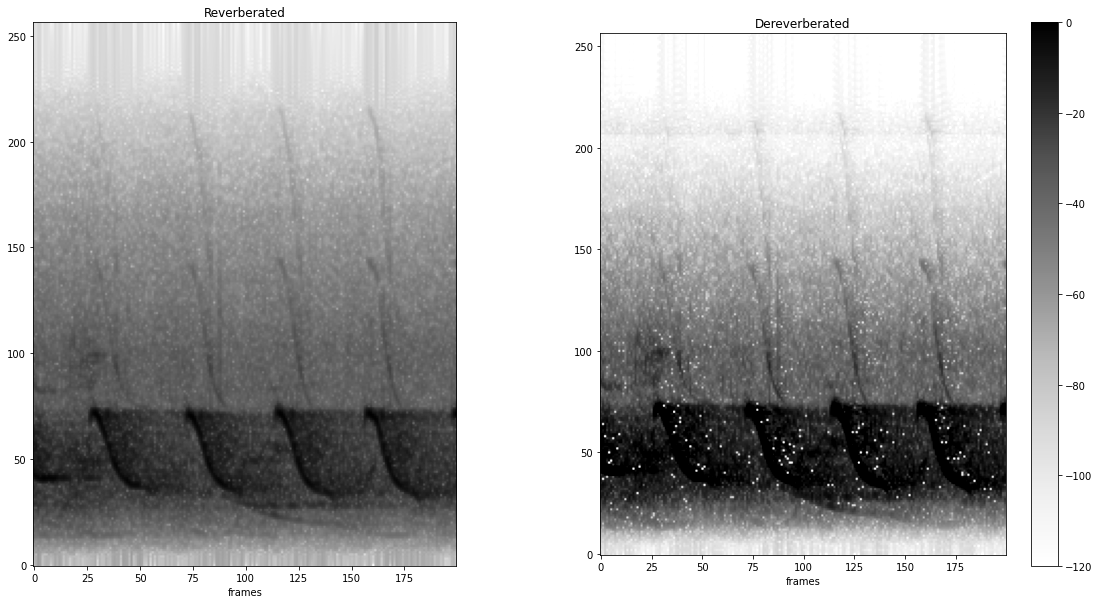

In [76]:
figsize = (20, 10)

fig, [ax1, ax2] = plt.subplots(
    1, 
    2, 
    figsize=figsize
)

im1 = ax1.imshow(
    20 * np.log10(
        np.abs(Y[ :, 0, 200:400])
    ), 
    origin='lower',
    cmap='Greys'
)

ax1.set_xlabel('frames')
ax1.set_title('Reverberated')

im2 = ax2.imshow(
    20 * np.log10(
        np.abs(Z[0, 200:400, :])
    ).transpose(), 
    origin='lower',
    cmap='Greys',
    vmin=-120, 
    vmax=0
)

ax2.set_xlabel('frames')
ax2.set_title('Dereverberated')

cb = fig.colorbar(im2)

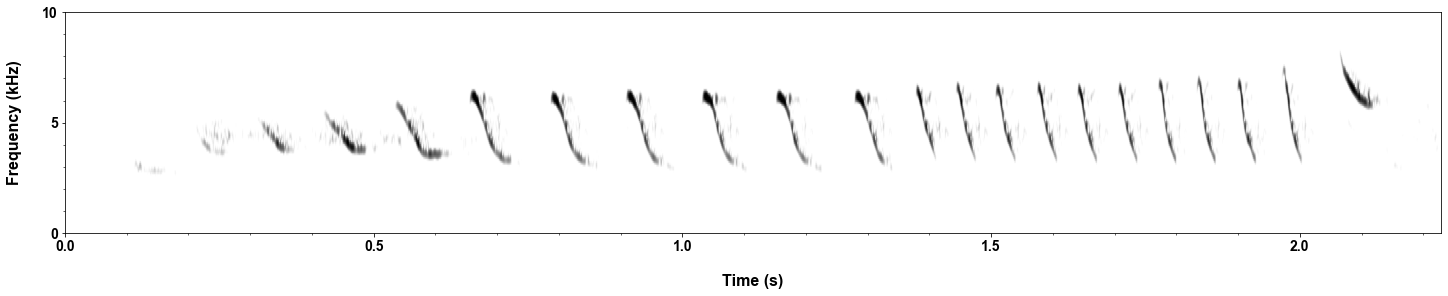

In [77]:
spectrogram = Spectrogram(reverberated, parameters)
spectrogram = spectrogram.generate()

plot = LusciniaSpectrogram(reverberated, spectrogram)
plot.create()

plt.show()

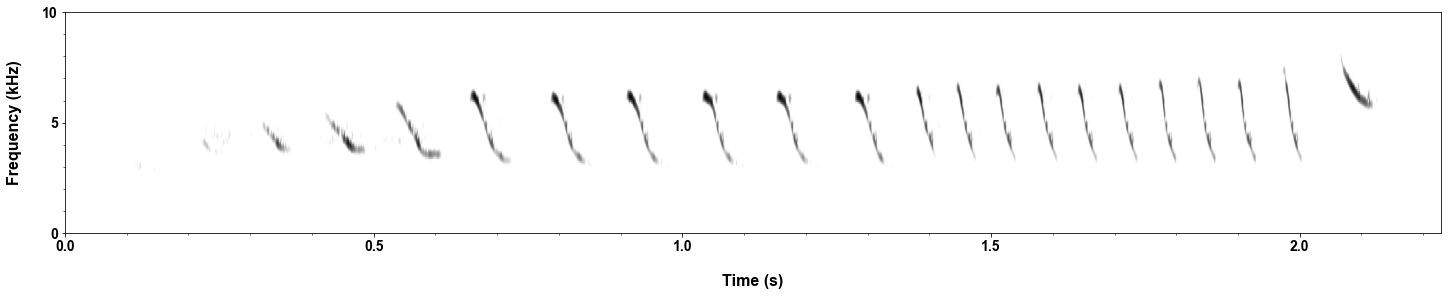

In [78]:
spectrogram = Spectrogram(dereverberated, parameters)
spectrogram = spectrogram.generate()

plot = LusciniaSpectrogram(dereverberated, spectrogram)
plot.create()

plt.show()